In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle 
import torch
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import json
import re

In [4]:
import argparse
import os

NEURAL_CONTROLLERS_DIR = os.environ['NEURAL_CONTROLLERS_DIR']
import sys
sys.path.append(NEURAL_CONTROLLERS_DIR)

from neural_controllers import NeuralController
from utils import load_model

### Llama

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds and methods
seeds = np.arange(5)
methods = ['rfm', 'linear', 'logistic']
# model_name = 'llama_3_8b_it'
model_name = 'llama_3.3_70b_4bit_it'
# Initialize dictionaries to store results
results = {
    'val': {method: {} for method in methods},
    'test': {method: {} for method in methods},
    'trivial_metrics_val': [],
    'trivial_metrics_test': [],
    'selected_test_metrics': {method: [] for method in methods}
}

# Load data for each method
for method in methods:
    # Initialize lists to store results for each seed
    for s in seeds:
        # Paths for validation and test metrics
        path_val = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model_name}_{method}_seed_{s}_val_metrics.pkl'
        path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model_name}_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if files exist
        if not os.path.exists(path_val):
            print(f"File not found: {path_val}")
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
            continue

            
        # Load validation and test results
        with open(path_val, 'rb') as f:
            val_results = pickle.load(f)
        with open(path_test, 'rb') as f:
            test_results = pickle.load(f)
        
        # Get layer keys
        layers_val = [k for k in val_results.keys() if isinstance(val_results[k], dict)]
        layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
        
        # Collect per-layer metrics
        for key in layers_val:
            if key not in results['val'][method]:
                results['val'][method][key] = []
            results['val'][method][key].append(val_results[key])
        
        for key in layers_test:
            if key not in results['test'][method]:
                results['test'][method][key] = []
            results['test'][method][key].append(test_results[key])
        
        # Identify best layer and store test metrics
        if layers_val:
            best_layer = max(layers_val, key=lambda x: val_results[x]['acc'])
            best_test_metrics = test_results.get(best_layer, {})
            results['selected_test_metrics'][method].append(best_test_metrics)

# Calculate and store averaged metrics
print("Best single layer")
averaged_metrics = defaultdict(lambda: defaultdict(dict))
for method in methods:
    test_metrics_list = results['selected_test_metrics'][method]
    if test_metrics_list:
        print(f"\n{method.upper()}:")
        metrics_dict = {}
        # Calculate mean and std for each metric
        for metric in test_metrics_list[0].keys():
            values = [metrics[metric] for metrics in test_metrics_list]
            mean_val = np.mean(values)
            std_val = np.std(values)
            metrics_dict[metric] = {'mean': mean_val, 'std': std_val}
            print(f"{metric}: {mean_val:.4f} ± {std_val:.4f}")
            # Store in averaged_metrics for potential further analysis
            averaged_metrics[method][metric] = {
                'mean': mean_val,
                'std': std_val
            }

Best single layer

RFM:
acc: 69.2000 ± 7.4404
precision: 0.6737 ± 0.0748
recall: 0.6983 ± 0.0842
f1: 0.6663 ± 0.0742
auc: 0.9190 ± 0.0100
mse: 0.0756 ± 0.0061

LINEAR:
acc: 67.2000 ± 4.3081
precision: 0.6504 ± 0.0249
recall: 0.6821 ± 0.0452
f1: 0.6495 ± 0.0325
auc: 0.9088 ± 0.0037
mse: 0.0774 ± 0.0052

LOGISTIC:
acc: 71.6000 ± 3.8781
precision: 0.7165 ± 0.0337
recall: 0.7273 ± 0.0425
f1: 0.7073 ± 0.0369
auc: 0.9020 ± 0.0180
mse: 2.8397 ± 0.4590


In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the methods
methods = ['rfm','linear', 'logistic']#, 'rfm_linear', 'linear_rfm']
# Initialize dictionary to store results
results = {
    'aggs_over_seeds': {method: [] for method in methods},
    'trivial_accs': []
}

# Load data for each method
for method in methods:        
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model_name}_{method}_seed_{s}_test_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            current_results = pickle.load(f)
            
        # Store linear_agg results
        if 'aggregation' in current_results:
            results['aggs_over_seeds'][method].append(current_results['aggregation'])

# Initialize dictionary for overall averages
overall_averages = defaultdict(lambda: defaultdict(dict))

# Print results
print("\nAccuracy Metrics (Aggregated Over Seeds):")

for method in methods:
    print(f"\n{method.upper()}:")
    aggs = results['aggs_over_seeds'][method]
    
    if aggs:
        # Get all metric keys from the first result
        metric_keys = aggs[0].keys()
        
        for metric in metric_keys:
            # Extract this metric from all seeds
            values = [result[metric] for result in aggs]
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")
            
            # Store for overall averages
            if method not in overall_averages[metric]:
                overall_averages[metric][method] = mean


Accuracy Metrics (Aggregated Over Seeds):

RFM:
acc: 69.2000 ± 7.2222
precision: 0.6825 ± 0.0663
recall: 0.6961 ± 0.0720
f1: 0.6762 ± 0.0610
auc: 0.9178 ± 0.0195
mse: 0.0721 ± 0.0095

LINEAR:
acc: 58.4000 ± 4.0792
precision: 0.5963 ± 0.0600
recall: 0.5855 ± 0.0430
f1: 0.5738 ± 0.0498
auc: 0.8261 ± 0.0478
mse: 0.1817 ± 0.0275

LOGISTIC:
acc: 64.4000 ± 4.6303
precision: 0.6745 ± 0.0694
recall: 0.6367 ± 0.0508
f1: 0.6321 ± 0.0603
auc: 0.8546 ± 0.0302
mse: 29.0167 ± 8.4784


## Judges

In [10]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Initialize dictionary to store all results
all_results = []

seeds = np.arange(5)  # Seeds to evaluate
judge_types = ['llama', 'openai']
judge_models = ['llama_3.3_70b_4bit_it', 'gpt-4o']

for judge_type, judge_model in zip(judge_types, judge_models):
    # Process results for all seeds
    for s in seeds:
        path = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{judge_type}_{judge_model}_seed_{s}_metrics.pkl'
        
        # Check if file exists
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
            
        with open(path, 'rb') as f:
            results = pickle.load(f)
            all_results.append(results)


    # Get all metric keys from the first result
    metric_keys = [k for k in all_results[0].keys()]
    
    print("\nJudge: {}, {} (averaged over seeds)".format(judge_model, judge_type))
    for metric in metric_keys:
        values = [result[metric] for result in all_results if isinstance(result[metric], (int, float))]
        if values:
            mean = np.mean(values)
            std = np.std(values)
            print(f"{metric}: {mean:.4f} ± {std:.4f}")


Judge: llama_3.3_70b_4bit_it, llama (averaged over seeds)
acc: 47.6000 ± 5.4259
precision: 0.4723 ± 0.0894
recall: 0.4565 ± 0.0911
f1: 0.4351 ± 0.0914
auc: 0.7754 ± 0.0276

Judge: gpt-4o, openai (averaged over seeds)
acc: 47.8000 ± 4.1425
precision: 0.4618 ± 0.0719
recall: 0.4714 ± 0.0703
f1: 0.4303 ± 0.0667
auc: 0.7826 ± 0.0242


### Layerwise

layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51, -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64, -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77, -78, -79, 'aggregation'])
layers [-79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]
layer_data.keys() dict_keys([-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31, 

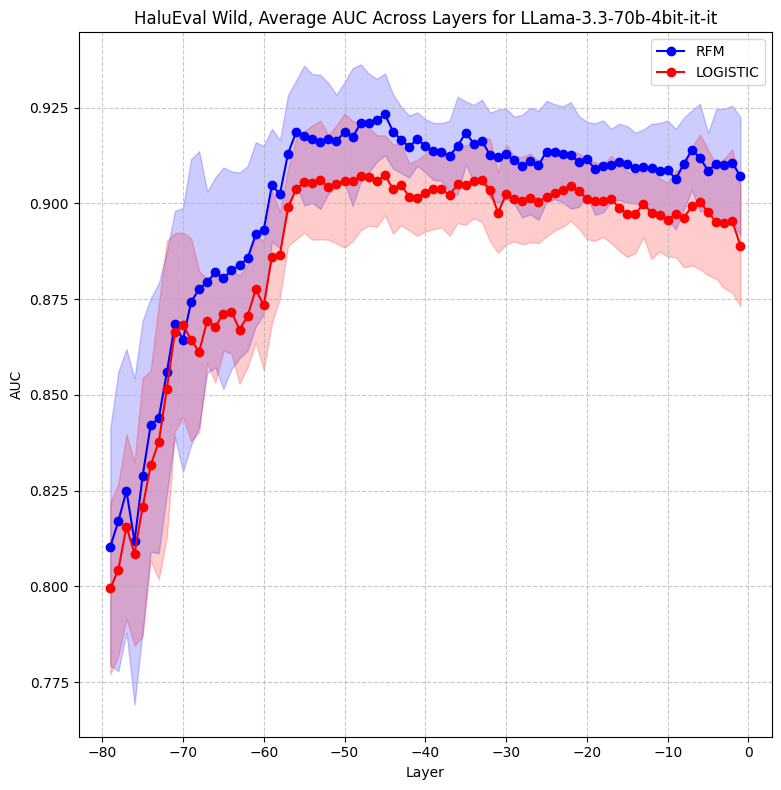

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
from collections import defaultdict

# Define the range of seeds
seeds = np.arange(5)
methods = ['rfm', 'logistic']
# models = ['llama_3_8b', 'gemma_2_9b']
models = ['llama_3.3_70b_4bit_it']
metric = 'auc'

# Initialize dictionaries to store results
all_results = {}

for model in models:
    all_results[model] = {
        'test': {method: {} for method in methods}
    }

    # Load data for each method
    for method in methods:
        # Process each seed
        for s in seeds:
            # Path for test metrics
            path_test = f'{NEURAL_CONTROLLERS_DIR}/results/halu_eval_wild_results/multiclass_{model}_{method}_seed_{s}_test_metrics.pkl'
            
            # Check if file exists
            if not os.path.exists(path_test):
                print(f"File not found: {path_test}")
                continue
                
            # Load test results
            with open(path_test, 'rb') as f:
                test_results = pickle.load(f)
            
            # Get layer keys (excluding non-dict entries)
            layers_test = [k for k in test_results.keys() if isinstance(test_results[k], dict)]
            
            # Collect per-layer metrics
            for key in layers_test:
                if key not in all_results[model]['test'][method]:
                    all_results[model]['test'][method][key] = []
                all_results[model]['test'][method][key].append(test_results[key][metric])

# Calculate average accuracies per layer
avg_results = {}
for model in models:
    avg_results[model] = {}
    for method in methods:
        avg_results[model][method] = {}
        for layer, accs in all_results[model]['test'][method].items():
            if accs:  # Check if we have data for this layer
                avg_results[model][method][layer] = {
                    'mean': np.mean(accs),
                    'std': np.std(accs)
                }


# Plot the results
plt.figure(figsize=(15, 8))

# Define colors and alpha values for shading
colors = {'rfm': 'blue', 'logistic': 'red'}
alpha_fill = 0.2  # Alpha transparency for the shaded region

for i, model in enumerate(models):
    plt.subplot(1, 2, i+1)
    
    for method in methods:
        layer_data = avg_results[model][method]
        print("layer_data.keys()", layer_data.keys())
        if layer_data:
            # Sort layers by their numerical value
            layers = sorted([int(layer) for layer in layer_data.keys() if isinstance(layer, int)])
            print("layers", layers)
            
            # Extract mean and std for plotting
            means = [layer_data[layer]['mean'] for layer in layers if layer in layer_data]
            stds = [layer_data[layer]['std'] for layer in layers if layer in layer_data]
            
            # Plot the mean line
            plt.plot(layers, means, label=method.upper(), marker='o', color=colors[method])
            
            # Add shaded error region
            plt.fill_between(
                layers, 
                [m - s for m, s in zip(means, stds)],  # lower bound
                [m + s for m, s in zip(means, stds)],  # upper bound
                color=colors[method], 
                alpha=alpha_fill
            )
    
    plt.title(f'HaluEval Wild, Average {metric.upper()} Across Layers for {model.replace(model[0], model[0].upper()).replace("_", "-")}-it')
    plt.xlabel('Layer')
    plt.ylabel(f'{metric.upper()}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

plt.savefig(f'plots/he_wild_test_{metric}_across_layers.pdf', format='pdf')
plt.show()